In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mbpls.data.get_data import load_FTIR_Data
from scipy.io import loadmat

In [2]:
data = load_FTIR_Data()

Following dataset were loaded as Pandas Dataframes:  dict_keys(['ftir1', 'ftir2', 'ftir3'])


In [3]:
ftir1 = data['ftir1']
wavenumbers = ftir1.columns
ftir2 = data['ftir2']
ftir3 = data['ftir3']

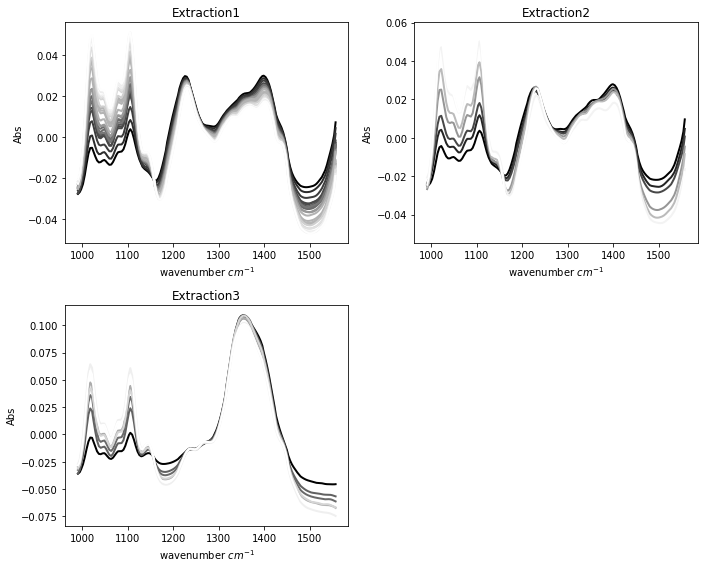

In [4]:
def plot_spectra(spectra, ax, name):
    pectin_yield = np.array(spectra.index)
    color_code = (pectin_yield - pectin_yield.min())
    color_code = color_code / color_code.max()
    color_code = color_code[:]
    for spectrum, color in zip(np.array(spectra), color_code):
        ax.plot(wavenumbers, spectrum, color=(color, color, color), linewidth=2)
        ax.set_title(name)
        ax.set_xlabel('wavenumber $cm^{-1}$')
        ax.set_ylabel('Abs')
        plt.tight_layout()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
plot_spectra(ftir1, ax[0][0], 'Extraction1')
plot_spectra(ftir2, ax[0][1], 'Extraction2')
plot_spectra(ftir3, ax[1][0], 'Extraction3')
ax[1][1].axis('off');

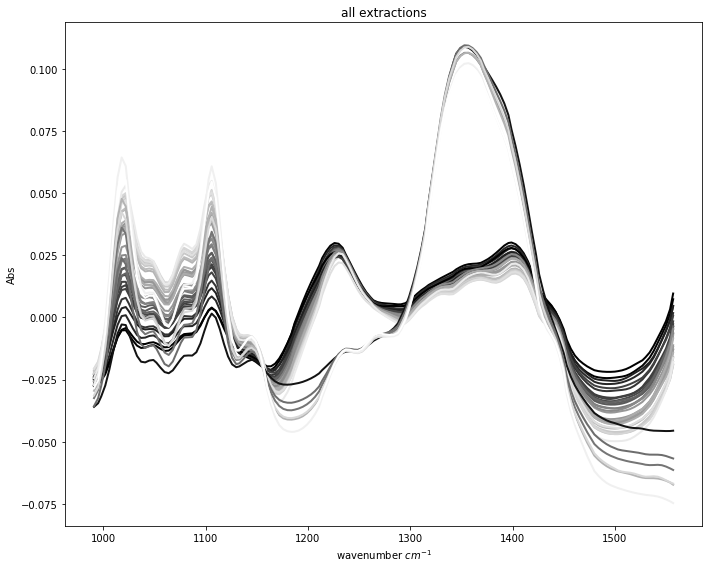

In [5]:
ftir = pd.concat((ftir1, ftir2, ftir3))
yield_all = np.array(ftir.index)
fig, ax = plt.subplots(figsize=(10,8))
plot_spectra(ftir, ax, 'all extractions')

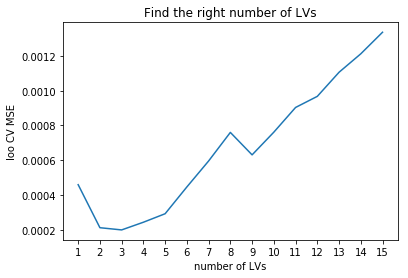

In [6]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

MSEs = []
for lv in range(15):
    mbpls = MBPLS(n_components=lv+1, method='NIPALS')
    prediction = cross_val_predict(mbpls, ftir, yield_all, cv=len(ftir))
    prediction = pd.DataFrame(prediction)
    MSEs.append(mean_squared_error(prediction, yield_all))

plt.plot(np.arange(1,16), MSEs)
plt.xlabel('number of LVs')
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.ylabel('loo CV MSE')
plt.title('Find the right number of LVs');

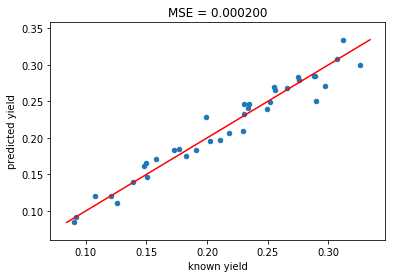

In [7]:
mbpls = MBPLS(n_components=3, method='NIPALS')
prediction = cross_val_predict(mbpls, ftir, yield_all, cv=len(ftir))
prediction = pd.DataFrame(prediction)
yield_all = pd.DataFrame(np.array(yield_all))
prediction = pd.concat((prediction, yield_all), axis=1)
prediction.columns=['predicted yield', 'known yield']
prediction.plot.scatter(x='known yield', y='predicted yield')
plt.plot([prediction.min().min(), prediction.max().max()], [prediction.min().min(), prediction.max().max()], color='red')
plt.title('MSE = %.6f' % mean_squared_error(prediction['known yield'], prediction['predicted yield']));

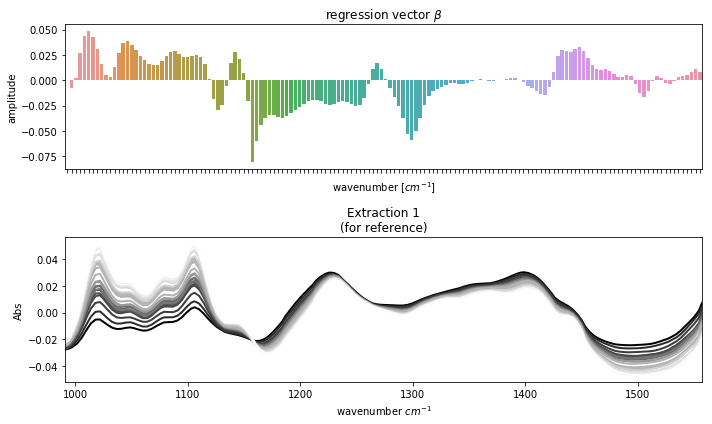

In [8]:
import seaborn as sns
mbpls = MBPLS(n_components=5, method='NIPALS')
mbpls.fit_transform(ftir, yield_all)
fig, ax = plt.subplots(nrows=2, figsize=(10,6))
sns.barplot(x=ftir.columns, y=mbpls.beta_[:,0], ax=ax[0])
ax[0].set_title('regression vector $\\beta$')
ax[0].set_xlabel('wavenumber $[cm^{-1}]$')
ax[0].set_ylabel('amplitude')
ax[0].axes.xaxis.set_ticklabels([])
plot_spectra(ftir1, ax[1], 'Extraction 1\n(for reference)')
ax[1].set_xlim([wavenumbers.min(), wavenumbers.max()]);